# RL Suite visualization

This notebook demonstrates how you can visualize experiment results in RL Suite. We'll walk through

- [loading experiment statistics](#Loading-experiment-statistics),
- [plotting results from a single experiment](#Plotting-a-single-run),
- [plotting results from multiple runs of a single experiment](#Plotting-multiple-runs), and
- [plot results from multiple experiments](#Plotting-multiple-experiments).

Some basic familiarity with `pandas` and `searborn` is useful but not required.

## Imports and constants

In [1]:
import os

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from rlsuite.algos import qlearning, mc_control, sarsa
from rlsuite.envs import gridworld
from rlsuite.utils import load_data


BASE_LOG_DIR = '/tmp/experiments'
ENV = 'GridWorld-v0'
NUM_EPISODES = 250
NUM_SEEDS = 25

## Running experiments

To generate data for our visualizations, we'll run three control algorithms -- Q-learning, Monte Carlo control, and Sarsa -- on the `GridWorld-v0` environment that comes with RL Suite. Each of these will be run for `NUM_EPISODES`, a total of `NUM_SEEDS` times, with different seeds, and the results will be stored in `BASE_LOG_DIR`, with a separate folder for each algorithm.

In [2]:
env_fn = lambda: gym.make(ENV)
for seed in range(NUM_SEEDS):
    qlearning(
        env_fn=env_fn,
        num_episodes=NUM_EPISODES,
        seed=seed,
        data_dir=os.path.join(BASE_LOG_DIR, 'viz_qlearning', f'run{seed}'),
    )
    mc_control(
        env_fn=env_fn,
        num_episodes=NUM_EPISODES,
        seed=seed,
        data_dir=os.path.join(BASE_LOG_DIR, 'viz_mc_control', f'run{seed}'),
    )
    sarsa(
        env_fn=env_fn,
        num_episodes=NUM_EPISODES,
        seed=seed,
        data_dir=os.path.join(BASE_LOG_DIR, 'viz_sarsa', f'run{seed}'),
    )

## Loading experiment statistics

RL Suite provides utilities for loading experiment data. The method `load_data` takes some root directory and recursively walks through all of its sub-directories to look for .tsv files containing experiment statistics. All such data is read and aggregated row-wise into a single dataframe. For example, to load the first run of Q-learning from above, we can do the following.

In [3]:
log_dir = os.path.join(BASE_LOG_DIR, 'viz_qlearning', 'run0')
data = load_data(log_dir, file_name='eval_statistics.tsv')
data.head(5)

iteration  episode_length  episode_return      time
run                                                       
0   0          0              15           -15.0  0.013371
    1          1              24           -24.0  0.025943
    2          2              50           -50.0  0.037167
    3          3              15           -15.0  0.045840
    4          4               1             0.0  0.046833

## Plotting a single run

Let's start by plotting the results from the run we just loaded. We can use `matplotlib` and `seaborn` to visualize the agent's performance. Suppose we are interested in how the algorithm's episode return changes over time. We may start by smoothing the `episode_return` column, and then create a `lineplot` that shows episode return vs. iteration number.

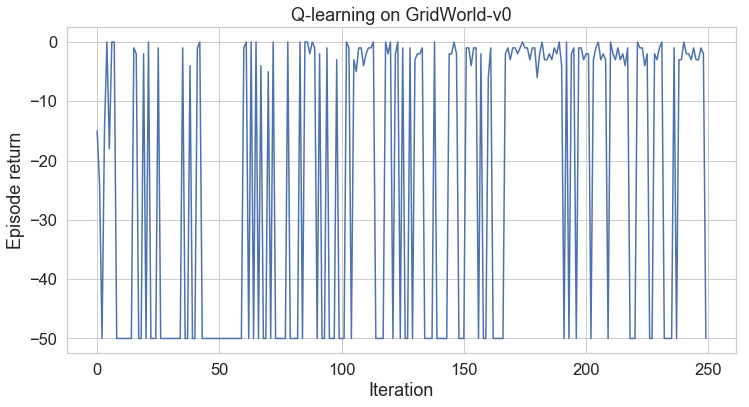

In [4]:
# Set default plot style for seaborn
sns.set(style="whitegrid", font_scale=1.5)

# Plot episode returns vs. iteration
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='iteration', y='episode_return')
plt.title('Q-learning on GridWorld-v0')
plt.xlabel('Iteration')
plt.ylabel('Episode return')
plt.show()

As you can see, the returns are quite noisy, so we might want to run the experiment multiple times and average the results. We'll show how to do this in the next section.

## Plotting multiple runs

Next, we'll aggregate the statistics data from all five runs of Q-learning, and use seaborn's `lineplot` function to create confidence bands around the mean episode return. The process is almost identical to what we did previously, except that we now want to provide the root directory of the five runs to `load_data` rather than just the first. Finally we need to tell seaborn that we would like to plot the confidence bands, which, by the way, are 1 standard deviation wide.

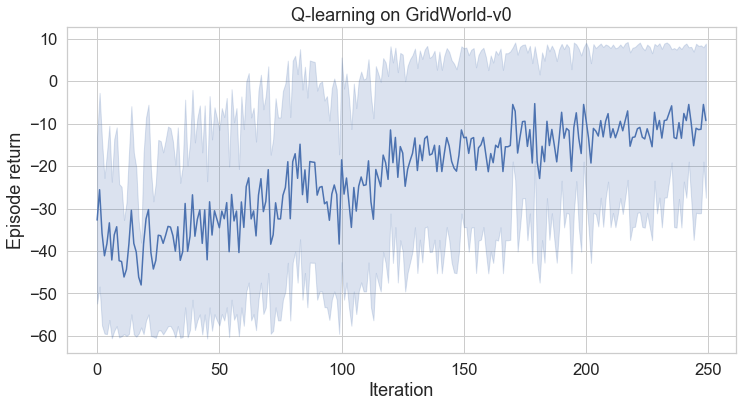

In [5]:
# Load data
log_dir = os.path.join(BASE_LOG_DIR, 'viz_qlearning')
data = load_data(log_dir, file_name='eval_statistics.tsv')

# Plot episode returns vs. iteration
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='iteration', y='episode_return', ci='sd')
plt.title('Q-learning on GridWorld-v0')
plt.xlabel('Iteration')
plt.ylabel('Episode return')
plt.show()

## Plotting multiple experiments

Finally, we'll combine statistics from multiple experiments and show them on the same plot. For this, we can use the `concat` method from pandas, along with `reset_index` in order to create a new column that indicates which experiment each row comes from.

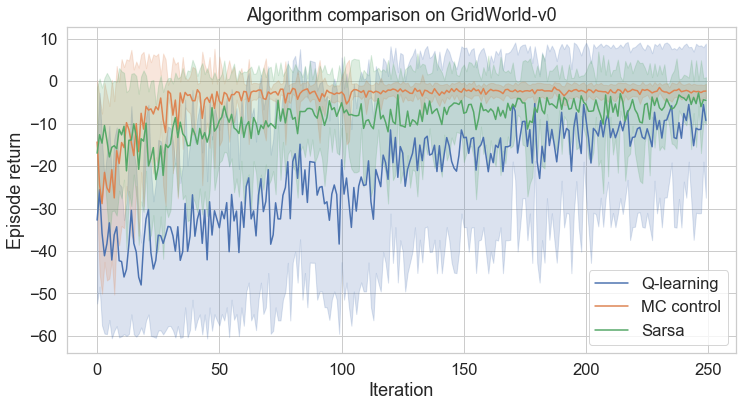

In [6]:
# Load data for each experiment
qlearning_data = load_data(os.path.join(BASE_LOG_DIR, 'viz_qlearning'), file_name='eval_statistics.tsv')
mc_control_data = load_data(os.path.join(BASE_LOG_DIR, 'viz_mc_control'))
sarsa_data = load_data(os.path.join(BASE_LOG_DIR, 'viz_sarsa'))

# Combine data
data = pd.concat(
    objs=[qlearning_data, mc_control_data, sarsa_data],
    keys=['qlearning', 'mc_control', 'sarsa'],
    names=['experiment'],
)
# Create column for experiment name
data.reset_index(level='experiment', inplace=True)

# Plot data
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='iteration', y='episode_return', hue='experiment', ci='sd')
h, l = plt.gca().get_legend_handles_labels()
plt.legend(loc='lower right', handles=h[1:], labels=['Q-learning', 'MC control', 'Sarsa'])
plt.title('Algorithm comparison on GridWorld-v0')
plt.xlabel('Iteration')
plt.ylabel('Episode return')
plt.show()